In [3]:
import sys, os
# add path to modules
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns
sns.set_style("whitegrid")

import dplot
from const import *

# Load data

In [4]:
# # description file -- not pandas-friendly
# df_dict = pd.read_excel('../data/pulse2020_data.dictionary_CSV_01.xlsx')

data = {
    n: pd.read_csv(f'../data/pulse2020_puf_{n:02d}.csv')
    for n in WEEK_IDX_RANGE
}
df = pd.read_csv('../data/pulse2020_puf_01.csv')

In [5]:
# check each participant has one entry in a given survey
for n in data.keys():
    assert len(data[n]['SCRAM'].unique()) == len(data[n])

# EDA

## Track participants over time

In [8]:
# base_week_idx = 6

# init_scram_set = set(data[base_week_idx]['SCRAM'])
# people_funnel = [len(init_scram_set)]

# for n in WEEK_IDX_RANGE[base_week_idx:]:
#     intersect_scram_set = init_scram_set.intersection(set(data[n]['SCRAM']))
#     people_funnel.append(len(intersect_scram_set))

# people_funnel

In [55]:
from functools import reduce

def get_participants_counts_matrix(data):
    df_list = []
    for week_idx, tmp_df in data.items():
        # make a df with column WEEK IDX 
        # which is has value WEEK IDX for participants of that week's survey
        tmp_df = tmp_df[['SCRAM']].copy()
        tmp_df.index = tmp_df.SCRAM
        tmp_df[str(week_idx)] = week_idx
        del tmp_df['SCRAM']
        df_list.append(tmp_df)

    # merge all dfs on SCRAM
    kwargs = dict(how='outer', left_index=True, right_index=True, )
    out = reduce(lambda x, y: pd.merge(x, y, **kwargs), df_list)

    # create matrix of size (n, k) = (num of all unique participants, number of weeks)
    # that propagates the idx of week when a person first joined 
    # to all following weeks IN WHICH this person participated
    out_nk = out.values
    is_valid_nk = np.isfinite(out_nk)
    out_nk[~is_valid_nk] = 100000
    out_nk = np.minimum.accumulate(out_nk, axis=1)
    out_nk[~is_valid_nk] = -1

    dim_k = out_nk.shape[1]
    # where k means from which week a person started to participate
    # and w is the week we are looking at to
    counts_kw = np.zeros((dim_k, dim_k))
    for k_idx in range(dim_k):
        counts_kw[k_idx] = (out_nk == k_idx + 1).sum(axis=0)

    df = pd.DataFrame(data=counts_kw, 
                      index=np.arange(1, dim_k + 1), 
                      columns=np.arange(1, dim_k + 1))
    df.index.name = 'start_week_idx'
    return df

In [56]:
df_kw = get_participants_counts_matrix(data)
# df_kw.to_csv('../data/participants_counts.csv')
counts_kw = df_kw.values

In [48]:
# check sum of paricipants for each week is same
weekly_num_people = np.array([len(data[i])for i in WEEK_IDX_RANGE])
assert ((df_kw.values.sum(axis=0) - weekly_num_people) == 0).all()

unique_person_ids = set()
for i in WEEK_IDX_RANGE:
    unique_person_ids.update(data[i]['SCRAM'].values)
assert np.diag(df_kw.values).sum() == len(unique_person_ids)

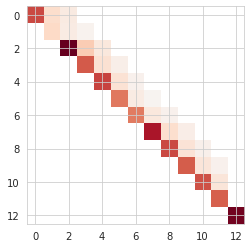

In [53]:


counts_kw_copy = counts_kw.copy()
counts_kw_copy[counts_kw_copy == 0] = np.nan
plt.imshow(counts_kw_copy, vmin=-counts_kw.max(), vmax=counts_kw.max(), cmap=cm.RdBu_r)

In [50]:


# Set the default color cycle

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "k", "c"]) 

In [51]:
clrs = sns.color_palette('gist_ncar', n_colors=13)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=clrs) 

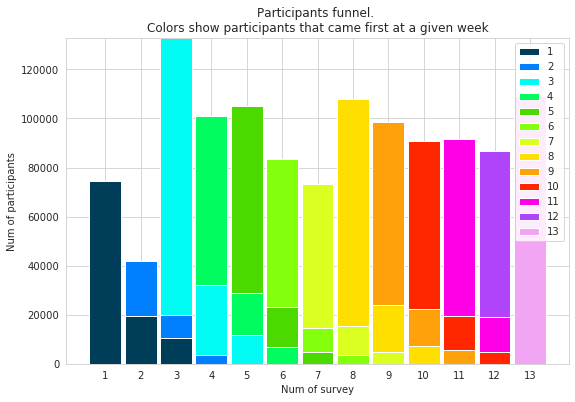

In [52]:
fig, axis = plt.subplots(1, 1, figsize=(9,6))

shifted_cum_counts_kw = np.concatenate((np.zeros(n_k)[None, :], counts_kw.cumsum(axis=0)), axis=0)
x_k = np.arange(1, n_k + 1)

for k_idx in range(n_k):
    p1 = axis.bar(x_k, counts_kw[k_idx], 0.9, 
                 bottom=shifted_cum_counts_kw[k_idx], label=k_idx + 1)
axis.xaxis.set_ticks(np.arange(1, 14, 1))
axis.set_title('Participants funnel. \nColors show participants that came first at a given week')
axis.set_xlabel('Num of survey')
axis.set_ylabel('Num of participants')
axis.legend()
fig.savefig('../figures/participants_funnel.png')

## EDA

In [17]:
race_from_num = {
    1: 'white',
    2: 'black',
    3: 'asian',
    4: 'other',
}

df['RRACE'].apply(lambda x: race_from_num[x]).value_counts()

white    61376
black     6258
other     3472
asian     3307
Name: RRACE, dtype: int64

## Number of variables over time

In [7]:
uniques_vars_v = set()
for i in WEEK_IDX_RANGE:
    uniques_vars_v.update(data[i].columns)
    
uniques_vars_v = np.array(sorted(uniques_vars_v))
is_included_vw = np.zeros((uniques_vars_v.shape[0], len(WEEK_IDX_RANGE)))

In [8]:
uniques_vars_v.size

205

In [85]:
data[i].columns

Index(['SCRAM', 'WEEK', 'EST_ST', 'EST_MSA', 'REGION', 'HWEIGHT', 'PWEIGHT',
       'TBIRTH_YEAR', 'ABIRTH_YEAR', 'EGENDER',
       ...
       'PSWHYCHG1', 'PSWHYCHG2', 'PSWHYCHG3', 'PSWHYCHG4', 'PSWHYCHG5',
       'PSWHYCHG6', 'PSWHYCHG7', 'PSWHYCHG8', 'PSWHYCHG9', 'INCOME'],
      dtype='object', length=188)

In [9]:
for w_idx, i in enumerate(data.keys()):
    is_included_vw[:, w_idx] = np.isin(uniques_vars_v, data[i].columns)

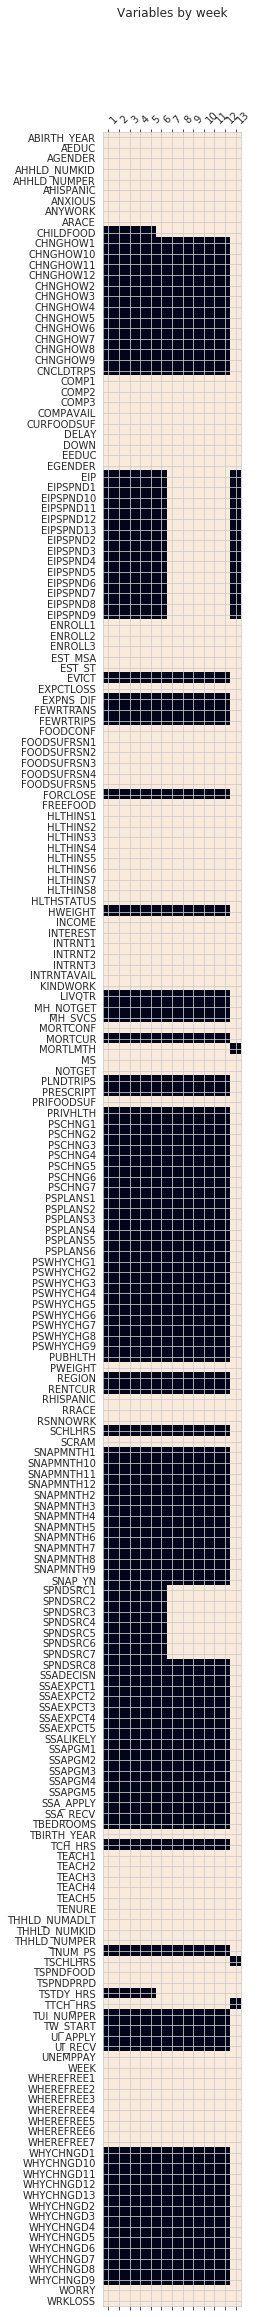

In [35]:
fig, axis = plt.subplots(figsize=(10, 40))
axis.matshow(is_included_vw, )

axis.set_xticks(np.arange(is_included_vw.shape[1]))
axis.set_xticklabels(np.arange(1, is_included_vw.shape[1] + 1), 
                     rotation=45, ha='left')

axis.set_yticks(np.arange(is_included_vw.shape[0]))
axis.set_yticklabels(uniques_vars_v)
axis.set_title('Variables by week');
# fig.savefig('../figures/variables_by_week.png')
# plt.grid(None)

## Distribution of demographics each week

In [97]:
data[1].columns

Index(['SCRAM', 'WEEK', 'EST_ST', 'EST_MSA', 'PWEIGHT', 'TBIRTH_YEAR',
       'ABIRTH_YEAR', 'EGENDER', 'AGENDER', 'RHISPANIC', 'AHISPANIC', 'RRACE',
       'ARACE', 'EEDUC', 'AEDUC', 'MS', 'THHLD_NUMPER', 'AHHLD_NUMPER',
       'THHLD_NUMKID', 'AHHLD_NUMKID', 'THHLD_NUMADLT', 'WRKLOSS', 'EXPCTLOSS',
       'ANYWORK', 'KINDWORK', 'RSNNOWRK', 'UNEMPPAY', 'PRIFOODSUF',
       'CURFOODSUF', 'FOODSUFRSN1', 'FOODSUFRSN2', 'FOODSUFRSN3',
       'FOODSUFRSN4', 'FOODSUFRSN5', 'FREEFOOD', 'WHEREFREE1', 'WHEREFREE2',
       'WHEREFREE3', 'WHEREFREE4', 'WHEREFREE5', 'WHEREFREE6', 'WHEREFREE7',
       'TSPNDFOOD', 'TSPNDPRPD', 'FOODCONF', 'HLTHSTATUS', 'ANXIOUS', 'WORRY',
       'INTEREST', 'DOWN', 'HLTHINS1', 'HLTHINS2', 'HLTHINS3', 'HLTHINS4',
       'HLTHINS5', 'HLTHINS6', 'HLTHINS7', 'HLTHINS8', 'DELAY', 'NOTGET',
       'TENURE', 'MORTLMTH', 'MORTCONF', 'ENROLL1', 'ENROLL2', 'ENROLL3',
       'TEACH1', 'TEACH2', 'TEACH3', 'TEACH4', 'TEACH5', 'COMPAVAIL', 'COMP1',
       'COMP2', 'COMP3', 'INT

In [98]:
data[1][['AGENDER', 'EGENDER']]

,AGENDER,EGENDER
0,2,2
1,2,1
2,2,2
3,2,1
4,2,2
...,...,...
74408,2,1
74409,2,2
74410,2,2
74411,2,2


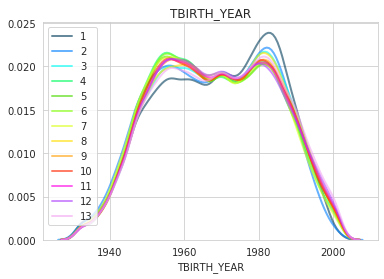

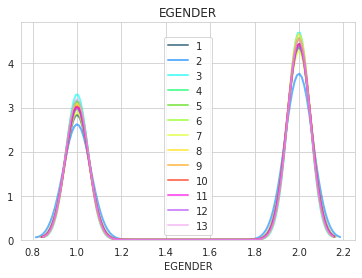

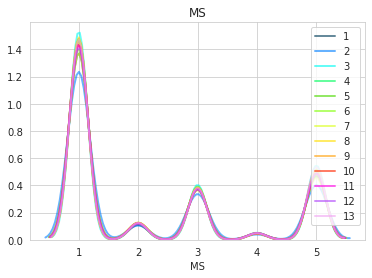

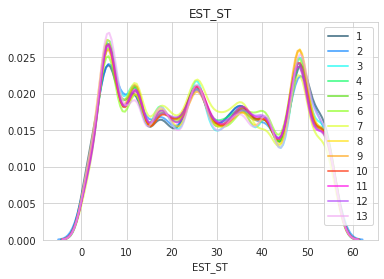

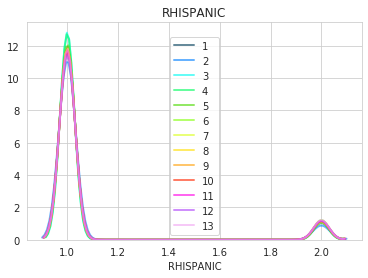

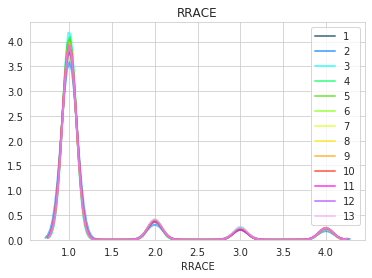

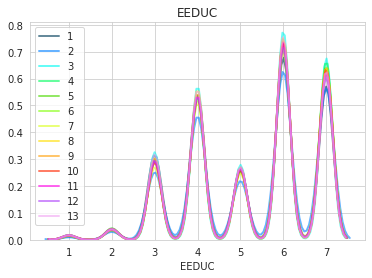

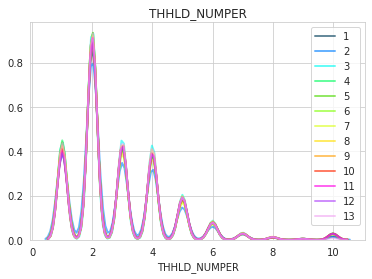

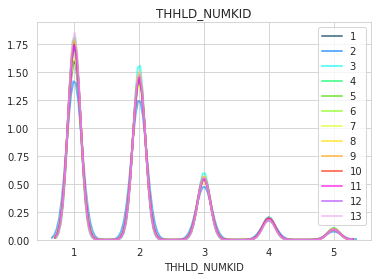

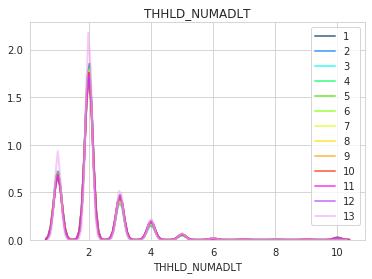

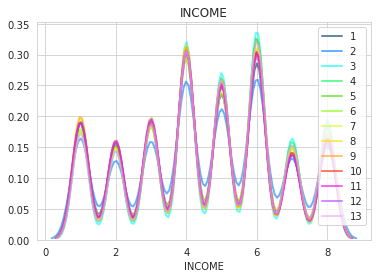

In [127]:
# week_idx = 1
for var in DEMOGRAPHICS_VARS:
    fig, axis = plt.subplots()
    for week_idx in data.keys():
        mask = (data[week_idx][var] > 0)
        sns.distplot(data[week_idx][var][mask], hist=False, kde=True, 
                 kde_kws={'linewidth': 2, 'alpha': 0.6},
                 label=week_idx)
#         axis.hist(data[week_idx][var][mask], bins=31, alpha=0.6, label=week_idx)
    axis.set_title(var)
    axis.legend()
    plt.show()

## Missing values

In [158]:
df = data[1].copy()

In [159]:
num = df._get_numeric_data()

In [160]:
num[num < 0] = np.nan

In [164]:
num.describe().T

,count,mean,std,min,25%,50%,75%,max
WEEK,74413.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0000
EST_ST,74413.0,28.072756,16.333008,1.000000,13.000000,27.000000,42.000000,56.0000
EST_MSA,22501.0,31848.246745,11630.493354,12060.000000,19100.000000,35620.000000,41860.000000,47900.0000
PWEIGHT,74413.0,3348.486367,6704.524462,21.403282,705.290358,1570.837162,3383.329425,328272.8743
TBIRTH_YEAR,74413.0,1969.065136,15.681818,1932.000000,1956.000000,1970.000000,1982.000000,2002.0000
...,...,...,...,...,...,...,...,...
INTRNT2,19119.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0000
INTRNT3,279.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0000
TSCHLHRS,19491.0,3.908736,5.516181,0.000000,0.500000,2.000000,5.000000,25.0000
TTCH_HRS,19449.0,13.486673,11.931108,0.000000,4.000000,10.000000,20.000000,48.0000


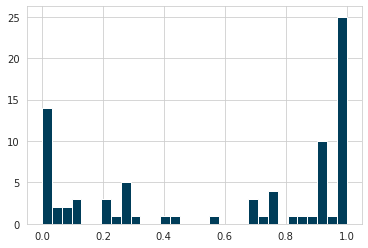

In [167]:
plt.hist(num.describe().T['count'] / len(df), bins=31);

In [170]:
num.describe().T['count']['WEEK']

74413.0

In [172]:
for var in WORK_VARS:
    print(var, num.describe().T['count'][var] / len(df))

WRKLOSS 0.9943961404593283
EXPCTLOSS 0.9927028879362477
ANYWORK 0.9938048459274589
KINDWORK 0.5522019002056092
RSNNOWRK 0.43011301788665957
UNEMPPAY 0.40480829962506554


## Correlations

In [183]:
HEALTH_VARS

['HLTHSTATUS', 'ANXIOUS', 'WORRY', 'INTEREST', 'DOWN']

HLTHSTATUS ANXIOUS


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


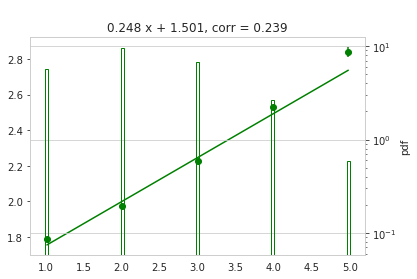

HLTHSTATUS WORRY


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


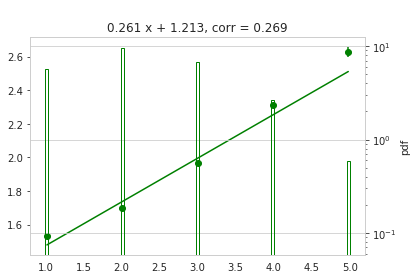

HLTHSTATUS INTEREST


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


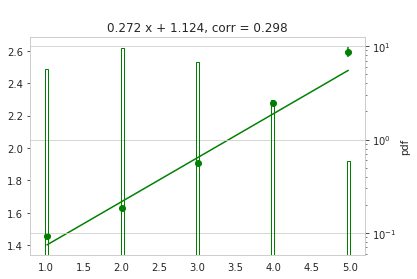

HLTHSTATUS DOWN


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


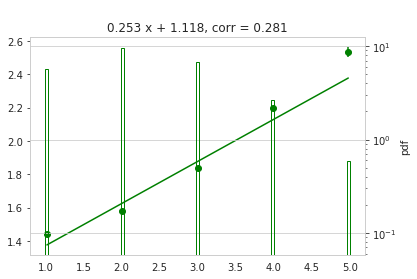

In [188]:
# var_1, var_2 = 'INTEREST', 'WORRY'
var_1 = 'HLTHSTATUS'
for var_2 in ['ANXIOUS', 'WORRY', 'INTEREST', 'DOWN']:
    print(var_1, var_2)
    week_idx = 1
    fig, axis = plt.subplots()
    mask = (data[week_idx][var_1] > 0) & (data[week_idx][var_2] > 0 )
    dplot.binned_plot(data[week_idx][var_1][mask], data[week_idx][var_2][mask], axis=axis)
    plt.show()

ANXIOUS ANXIOUS


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


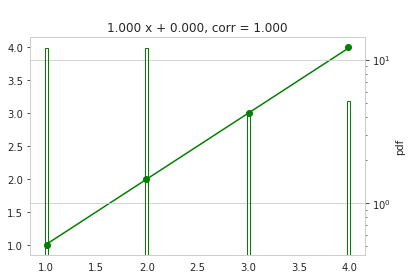

ANXIOUS WORRY


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


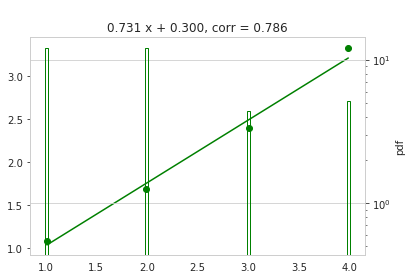

ANXIOUS INTEREST


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


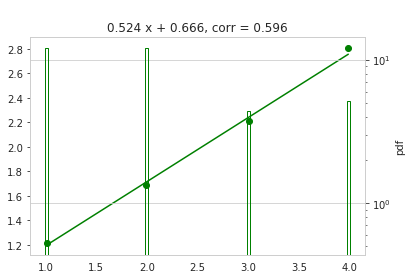

ANXIOUS DOWN


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


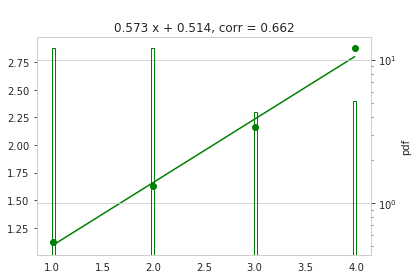

WORRY ANXIOUS


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


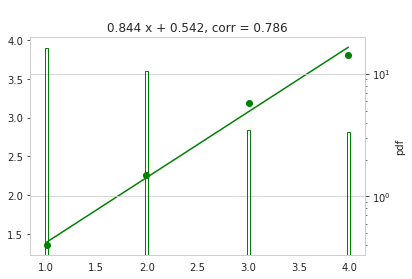

WORRY WORRY


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


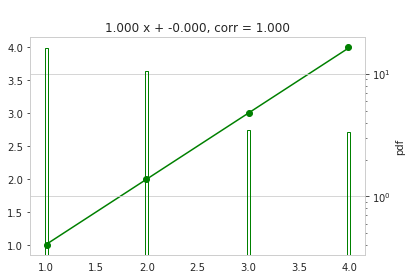

WORRY INTEREST


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


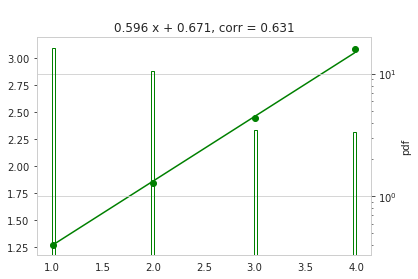

WORRY DOWN


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


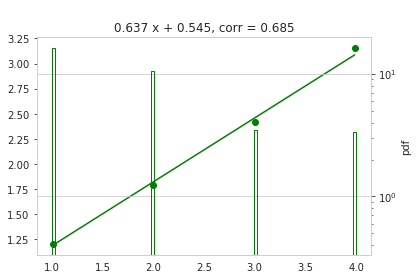

INTEREST ANXIOUS


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


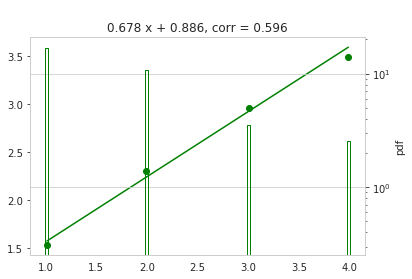

INTEREST WORRY


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


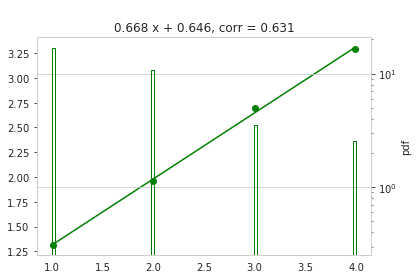

INTEREST INTEREST


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


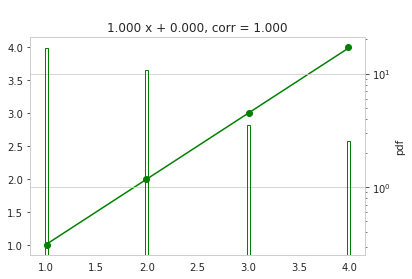

INTEREST DOWN


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


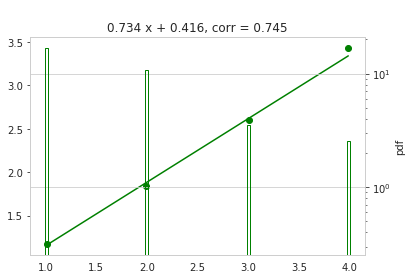

DOWN ANXIOUS


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


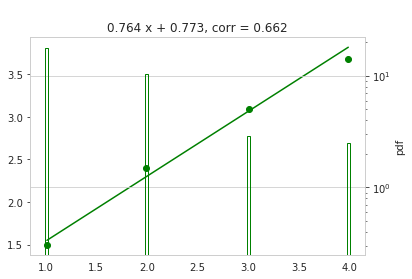

DOWN WORRY


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


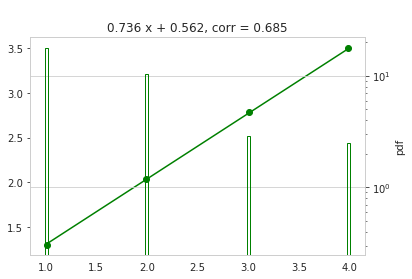

DOWN INTEREST


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


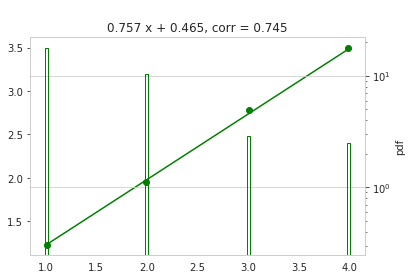

DOWN DOWN


/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:17: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x, y, statistic="count", bins=n_bins)[0])
/home/marina/Documents/women_summit/DS4A-Women-Summit/dplot.py:28: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  normed=True, log=True)


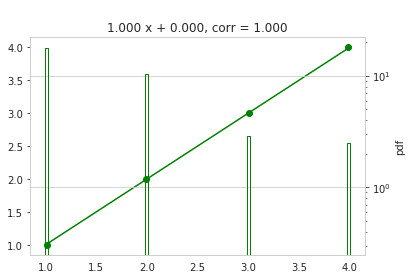

In [191]:
# var_1, var_2 = 'INTEREST', 'WORRY'

for var_1, var_2 in product(['ANXIOUS', 'WORRY', 'INTEREST', 'DOWN'], ['ANXIOUS', 'WORRY', 'INTEREST', 'DOWN']):
    print(var_1, var_2)
    week_idx = 1
    fig, axis = plt.subplots()
    mask = (data[week_idx][var_1] > 0) & (data[week_idx][var_2] > 0 )
    dplot.binned_plot(data[week_idx][var_1][mask], data[week_idx][var_2][mask], axis=axis)
    plt.show()

In [189]:
from itertools import product

In [190]:
product(['ANXIOUS', 'WORRY', 'INTEREST', 'DOWN'], ['ANXIOUS', 'WORRY', 'INTEREST', 'DOWN'])